In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df=pd.read_excel("D:/Digital Hashtag Internship/Project 1/1. Red Wine Quality Prediction/1. Red Wine Quality Prediction/winequality-red.xlsx", engine='openpyxl')

In [3]:
df.shape

(1599, 12)

In [4]:
# checking the duplicate records
df[df.duplicated()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


In [5]:
# removing duplicate records
df.drop_duplicates(inplace=True)
df.shape

(1359, 12)

In [6]:
# converting quality column into binary classification
from collections import Counter
df["target"] = df["quality"].apply(
        lambda q: 1 if q >= 7 else 0)

X = df.drop(["quality", "target"], axis=1)
y = df["target"]

print("New Distribution:", Counter(y))
print("Feature Matrix Shape:", X.shape)


New Distribution: Counter({0: 1175, 1: 184})
Feature Matrix Shape: (1359, 11)


In [7]:
# Handling Imbalanced Data using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

balanced_df = pd.DataFrame(X_bal, columns=X.columns)
balanced_df["target"] = y_bal


In [8]:
balanced_df.to_csv("wine_balanced.csv", index=False)

In [9]:
df = pd.read_csv("wine_balanced.csv")

X = df.drop("target", axis=1)
y = df["target"]

In [10]:
# Training , testing and splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal,test_size=0.2,random_state=42)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)

X_train Shape: (1880, 11)
X_test Shape: (470, 11)


In [11]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train Shape:", X_train_scaled.shape)
print("Test Shape:", X_test_scaled.shape)


Train Shape: (1880, 11)
Test Shape: (470, 11)


In [12]:
# Model Comparison Function
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def check_best_algo(X_train, X_test, y_train, y_test):
    models = {

      "Logistic_Regression":
          LogisticRegression(max_iter=500),

      "Decision_Tree":
          DecisionTreeClassifier(),

      "Random_Forest":
          RandomForestClassifier(),

      "XGBoost":
          XGBClassifier(
             use_label_encoder=False,
             eval_metric="logloss")
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc = accuracy_score(y_test, pred)
        results[name] = round(acc, 4)

    best_name = max(results, key=results.get)
    best_acc  = results[best_name]

    print("All Algorithm Accuracies:", results)
    print("Best Algorithm for This Data:", best_name)
    print("Best Accuracy:", best_acc)

    return results, best_name


In [13]:
# Checking Best Algorithm
accuracies, best = check_best_algo(
        X_train_scaled,
        X_test_scaled,
        y_train,
        y_test)


All Algorithm Accuracies: {'Logistic_Regression': 0.8255, 'Decision_Tree': 0.8787, 'Random_Forest': 0.917, 'XGBoost': 0.9319}
Best Algorithm for This Data: XGBoost
Best Accuracy: 0.9319


Feature Ranking:
alcohol                 0.256955
sulphates               0.164991
volatile acidity        0.122163
citric acid             0.073806
density                 0.072289
total sulfur dioxide    0.062785
fixed acidity           0.062404
chlorides               0.049210
residual sugar          0.047613
free sulfur dioxide     0.045983
pH                      0.041799
dtype: float64


Text(0.5, 0, 'Importance Score')

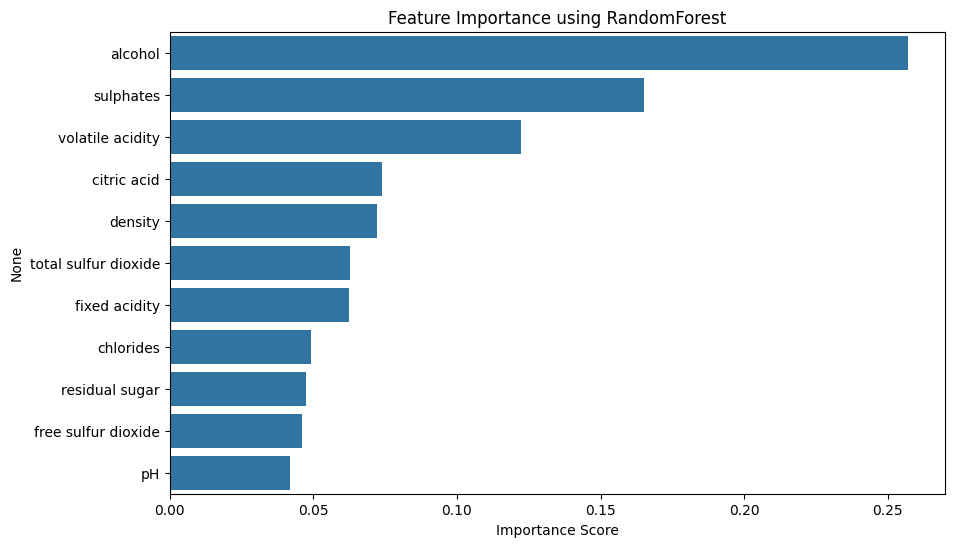

In [14]:
# Feature Importance using RandomForest
imp_model = RandomForestClassifier(random_state=42)

imp_model.fit(X_train_scaled, y_train)
importance = pd.Series(
        imp_model.feature_importances_,
        index=X.columns)

print("Feature Ranking:")
print(importance.sort_values(ascending=False))

# Plotting Feature Importance
plt.figure(figsize=(10,6))  
sns.barplot(x=importance.sort_values(ascending=False), y=importance.sort_values(ascending=False).index)
plt.title('Feature Importance using RandomForest')
plt.xlabel('Importance Score')



In [15]:
# Selecting Top K Important Features

top_k = 7

top_features = importance.sort_values(
                 ascending=False).head(top_k).index.tolist()
X_train_df = pd.DataFrame(
        X_train_scaled, columns=X.columns)
X_test_df  = pd.DataFrame(
        X_test_scaled,  columns=X.columns)
X_train_imp = X_train_df[top_features]
X_test_imp  = X_test_df[top_features]

print("Selected Features:", top_features)
print("Important Train Shape:", X_train_imp.shape)


Selected Features: ['alcohol', 'sulphates', 'volatile acidity', 'citric acid', 'density', 'total sulfur dioxide', 'fixed acidity']
Important Train Shape: (1880, 7)


In [16]:
acc_imp, best_imp = check_best_algo(
        X_train_imp,
        X_test_imp,
        y_train,
        y_test)
print("Best Model after Feature Selection:", best_imp)

All Algorithm Accuracies: {'Logistic_Regression': 0.817, 'Decision_Tree': 0.8723, 'Random_Forest': 0.9043, 'XGBoost': 0.9021}
Best Algorithm for This Data: Random_Forest
Best Accuracy: 0.9043
Best Model after Feature Selection: Random_Forest


In [17]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [18]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

param_xgb = {

 "n_estimators": [50, 100, 200],
 "max_depth": [3, 6, 10],
 "learning_rate": [0.01, 0.1, 0.2],
 "subsample": [0.6, 0.8, 1.0],
 "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42)

search_xgb = GridSearchCV(
        xgb,
        param_xgb,
        cv=5)

search_xgb.fit(X_train_scaled, y_train)

print("Best Parameters:", search_xgb.best_params_)

Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


In [19]:
best_xgb = search_xgb.best_estimator_

best_pred = best_xgb.predict(X_test_scaled)
print("Tuned Accuracy:",
        accuracy_score(y_test, best_pred))

print("Tuned Report:")
print(classification_report(y_test, best_pred))


Tuned Accuracy: 0.925531914893617
Tuned Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       232
           1       0.90      0.96      0.93       238

    accuracy                           0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470



In [20]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

xgb_default = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42)

scores = cross_val_score(
        xgb_default,
        X_train_scaled,
        y_train,
        cv=5)

print("Average CV Accuracy:", scores.mean())


Average CV Accuracy: 0.9191489361702129


In [21]:
# Final Evaluation on Train and Test Sets
train_acc = accuracy_score(
       y_train,
       xgb_default.fit(X_train_scaled, y_train)
                  .predict(X_train_scaled))

test_acc  = accuracy_score(
       y_test,
       xgb_default.predict(X_test_scaled))

print("Train:", train_acc,
      "Test:", test_acc)


Train: 1.0 Test: 0.9319148936170213


In [22]:
# Final Model Training and Prediction
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
        eval_metric="logloss",
        random_state=42)

xgb_model.fit(X_train_scaled, y_train)

xgb_pred = xgb_model.predict(X_test_scaled)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))

print("XGBoost Report:")
print(classification_report(y_test, xgb_pred))


XGBoost Accuracy: 0.9319148936170213
XGBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       232
           1       0.91      0.97      0.93       238

    accuracy                           0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470



In [25]:
# saving the model using joblib
import joblib
joblib.dump(xgb_model, 'xgb_wine_model.joblib')

['xgb_wine_model.joblib']

Confusion Matrix:
[[208  24]
 [  8 230]]


<Axes: >

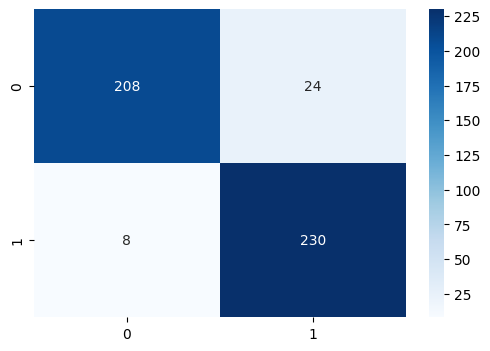

In [23]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, xgb_pred)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')



ROC AUC: 0.9765647638365691


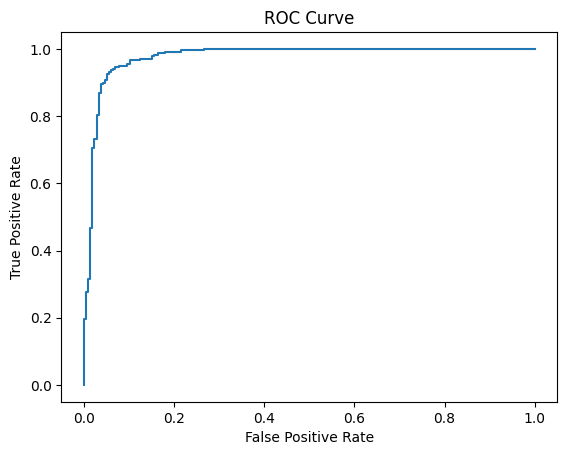

In [24]:
# ROC AUC Curve
from sklearn.metrics import roc_curve, auc
y_score = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_value = auc(fpr, tpr)
print("ROC AUC:", roc_value)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()
